<h2>Goal:</h2>
Write functions to subdivide an m/z : rt space into rt bins. See how this affects classification performance

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
%matplotlib inline

Start with MTBLS315, the malaria vs fever dataset. Could get ~0.85 AUC for whole dataset.

In [2]:
# Get the data
### Subdivide the data into a feature table
local_path = '/home/irockafe/Dropbox (MIT)/Alm_Lab/projects/'
data_path = local_path + '/revo_healthcare/data/processed/MTBLS315/'\
'uhplc_pos/xcms_camera_results.csv'

## Import the data and remove extraneous columns
df = pd.read_csv(data_path, index_col=0)
df.shape
df.head()

not_samples=['']

Almost everything is below 30sec rt-window

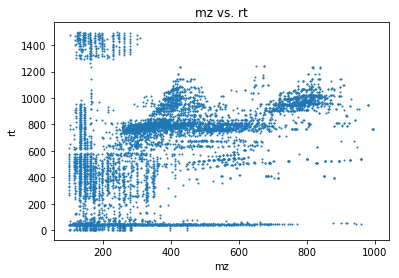

In [3]:
# Show me a scatterplot of m/z rt dots
# distribution along mass-axis and rt axist

plt.scatter(df['mz'], df['rt'], s=1,)
plt.xlabel('mz')
plt.ylabel('rt')
plt.title('mz vs. rt')
plt.show()



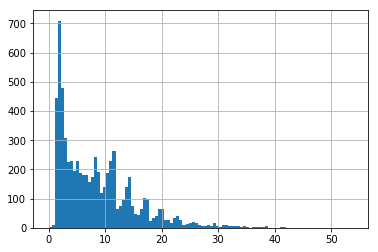

In [4]:
# Check out the distribution of rt-windows to choose your rt bin
rt_dist = df['rtmax'] - df['rtmin']
rt_dist.hist(bins=100)
# Choose to use 40 second bins...? 

In [ ]:
# Divide m/z and rt into windows of certain width

def subdivide_mz_rt(df, rt_bins, mz_bins, samples, not_samples):
    '''
    GOAL - Subdivide mz/rt space into a grid of defined widths. Sum entrie sof the grid
    IPUT - df - dataframe from xcms (rt, mz, patient names as columns)
    OUTPUT - Matrix containing summed intensities
    NOTE - Do adducts play a large roll here? Uncertain. Could choose your rt-widths based on
           rt-distribution
    '''
    # Define the bins based on separation criteria
    # todo this is hacky and will always round down
    rt_window = df['rt'].max() / rt_bins
    rt_bounds = [(i*rt_window, i*rt_window+rt_window) 
                 for i in range(0, rt_bins)]

    mz_window = df['mz'].max() / mz_bins
    mz_bounds = [(i*mz_window, i*mz_window+mz_window) 
                for i in range(0, mz_bins)]
        
    # Tidy up by converting patient labels to column using melt
    tidy = pd.melt(df, id_vars=not_samples,
           value_vars=samples, var_name='Samples', 
           value_name='Intensity')
    
    # Go through each sample and sum intensities onto grid
    grid_dict = {}
    for sample in samples:
        # Initiate empty dict with shape mz_windo x rt_window
        grid_vals = np.zeros([mz_bins, rt_bins])
        
        df_sample = tidy[tidy['Samples'] == sample]
        # use floor, b/c zero is the start of indexes, not 1
        # TODO Deal with 
        y_vals = np.floor(df_sample['rt'].div(
                    df_sample['rt'].max()+1e-9)*rt_bins
                        ).astype(int)
        x_vals = np.floor(df_sample['mz'].div(
                        df_sample['mz'].max()+1e-9)*mz_bins
                        ).astype(int)
        df_sample['rt_bin'] = x_vals
        df_sample['mz_bin'] = y_vals
        # Go through each row and add intensity to the correct 
        # grid-entry
        for idx, row in df_sample.iterrows():
            grid_vals[row['rt_bin'], row['mz_bin']] += row['Intensity']
                    
        # Add to grid dict
        grid_dict[sample] = grid_vals
        ax = sns.heatmap(grid_vals)
        ax.set_xlabel('mz')
        ax.set_ylabel('rt')
        ax.invert_yaxis()
        plt.title(sample)
        plt.show()
    
    # Create matrix to add intensities to
    
    # Get the number of bins by finding hte max values of m/z and 
    return grid_dict

not_samples = ['mz', 'mzmin', 'mzmax', 'rt', 'rtmin', 'rtmax',
              'adduct', 'isotopes', 'npeaks', 'pcgroup', 'uhplc_pos']
samples = df.columns.difference(not_samples)
print 'max:', df['mz'].max()
rt_divisor = 50 # base this on distribution of rt-widths..?
mz_bins = 5
rt_bins = 5
print mz_bins
print rt_bins
grid_dict = subdivide_mz_rt(df, mz_bins, rt_bins, samples, not_samples)

max: 994.676397959
5
5


/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [92]:
# Make shit tidy
test_df = pd.DataFrame({'mz': [10,20,30,100], 'rt':[100,200,300,1000], 
                        'A': [1,2,3,4], 'B': [10,20,30,40],
                       'C': [5,15,25,35]})
print 'Original: \n', test_df
tidy_df = pd.melt(test_df, id_vars=['mz', 'rt'], value_vars=['A', 'B', 'C'], 
       var_name='Subject', value_name='Intensity')
print '\n\n Tidy:\n', tidy_df

feature_table_df = pd.pivot_table(tidy_df, index=['mz', 'rt'], values='Intensity',
                           columns='Subject')

print '\n\n Unpivoted, step 1:\n',feature_table_df

feature_table_df.reset_index(inplace=True)
print feature_table_df


abc = tidy_df[tidy_df['Subject'] == 'A']

Original: 
   A   B   C   mz    rt
0  1  10   5   10   100
1  2  20  15   20   200
2  3  30  25   30   300
3  4  40  35  100  1000


 Tidy:
     mz    rt Subject  Intensity
0    10   100       A          1
1    20   200       A          2
2    30   300       A          3
3   100  1000       A          4
4    10   100       B         10
5    20   200       B         20
6    30   300       B         30
7   100  1000       B         40
8    10   100       C          5
9    20   200       C         15
10   30   300       C         25
11  100  1000       C         35


 Unpivoted, step 1:
Subject   A   B   C
mz  rt             
10  100   1  10   5
20  200   2  20  15
30  300   3  30  25
100 1000  4  40  35
Subject   mz    rt  A   B   C
0         10   100  1  10   5
1         20   200  2  20  15
2         30   300  3  30  25
3        100  1000  4  40  35


In [120]:
a = np.zeros([2,6])
a[0.0,2.0] += 3
a[0,2]+=7
a

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [84]:
# divide feature table into slices of retention time
def get_rt_slice(df, rt_bounds):
    '''
    PURPOSE: 
        Given a tidy feature table with 'mz' and 'rt' column headers, 
        retain only the features whose rt is between rt_left 
        and rt_right
    INPUT: 
        df - a tidy pandas dataframe with 'mz' and 'rt' column 
            headers
        rt_left, rt_right: the boundaries of your rt_slice, in seconds
    '''
    out_df = df.loc[ (df['rt'] > rt_bounds[0]) & 
                    (df['rt'] < rt_bounds[1])]
    return out_df

def sliding_window_rt(df, rt_width, step=rt_width*0.25):
    pass
    # get range of values [(0, rt_width)
    #get_rt_slice(df, )
    rt_min = np.min(df['rt'])
    rt_max = np.max(df['rt'])
    # define the ranges 
    left_bound = np.arange(rt_min, rt_max, step)
    right_bound = left_bound + rt_width
    rt_bounds = zip(left_bound, right_bound)
    for rt_slice in rt_bounds:
        rt_window = get_rt_slice(df, rt_slice)
        #print rt_window.head()
        print 'shape', rt_window.shape
        raise hee
        # TODO Send to ml pipeline here? Or separate function?

print type(np.float64(3.5137499999999999))
a = get_rt_slice(df, (750, 1050))
print 'Original dataframe shape: ', df.shape
print '\n Shape:', a.shape, '\n\n\n\n'

sliding_window_rt(df, 100)

NameError: name 'rt_width' is not defined

In [16]:
# Convert selected slice to feature table, X, get labels y

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,uhplc_pos,X1001_P,X1002_P,...,X1061_P,X1062_P,X1064_P,X1065_P,X1066_P,X1067_P,X1068_P,isotopes,adduct,pcgroup
37,104.106489,104.106064,104.106715,769.177526,768.010462,778.193106,67,55,329070.128055,396227.894115,...,473247.278829,588871.216421,426270.960560,572473.584864,569940.613228,315394.476526,944484.900497,NaN,NaN,442
38,104.106481,104.105924,104.106715,797.843875,796.921036,799.168518,53,51,65338.750793,79133.729755,...,185880.697595,128276.011237,205495.778470,231927.971052,210661.425303,164378.532642,274995.481829,NaN,NaN,33
44,112.627395,112.626903,112.627604,768.882724,768.164720,769.627506,34,34,0.000000,2512.603634,...,17939.896362,19085.291535,24771.295474,34058.985162,59346.107589,43265.770580,90047.112008,NaN,NaN,11
87,117.988387,117.987919,117.988599,912.162783,903.569648,919.857546,58,34,316999.738260,557646.282622,...,413286.737731,392384.888350,969722.728147,241978.478925,401799.805418,402536.825821,387827.492260,NaN,NaN,968
92,117.988391,117.987949,117.988588,895.832264,889.220909,902.494494,49,32,443674.518761,360580.907258,...,278985.527029,296287.274749,274575.084114,255087.820263,248857.829020,274409.550916,243281.723691,NaN,NaN,57


<h2> Show me the distribution of features from alzheimers dataset </h2>

In [88]:
### Subdivide the data into a feature table
local_path = '/home/irockafe/Dropbox (MIT)/Alm_Lab/'\
'projects'
data_path = local_path + '/revo_healthcare/data/processed/MTBLS72/positive_mode/'\
'mtbls_no_retcor_bw2.csv'
## Import the data and remove extraneous columns
df = pd.read_csv(data_path, index_col=0)
df.shape
df.head()
# Make a new index of mz:rt
mz = df.loc[:,"mz"].astype('str')
rt = df.loc[:,"rt"].astype('str')
idx = mz+':'+rt
df.index = idx
df.head()

a = get_rt_slice(df, (0,100))
print df.shape
print a.shape

(1417, 262)
(517, 262)
